## Ejercicio: Predicción presencia de enfermedad con Máquinas de Soporte de Vectores .

Para este ejercicio trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. 

El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predica de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria. 

Para más detalles técnicos asociados a la base de datos, pueden hacer click en https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

### 1. Preparar el ambiente de trabajo.

Importe todas las librerías a utilizar. 

Fije los parámetros de los gráficos con plt.Rcparams. 

Excluya las columnas id y Unnamed: 32 de la base de datos. 

Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(6, 6)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import funciones_svm as fn

In [2]:
df= pd.read_csv('breast_cancer.csv').drop(columns=['id','Unnamed: 32'])


In [3]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

### 2. Visualizando la distribución de los atributos.

Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo. 

Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

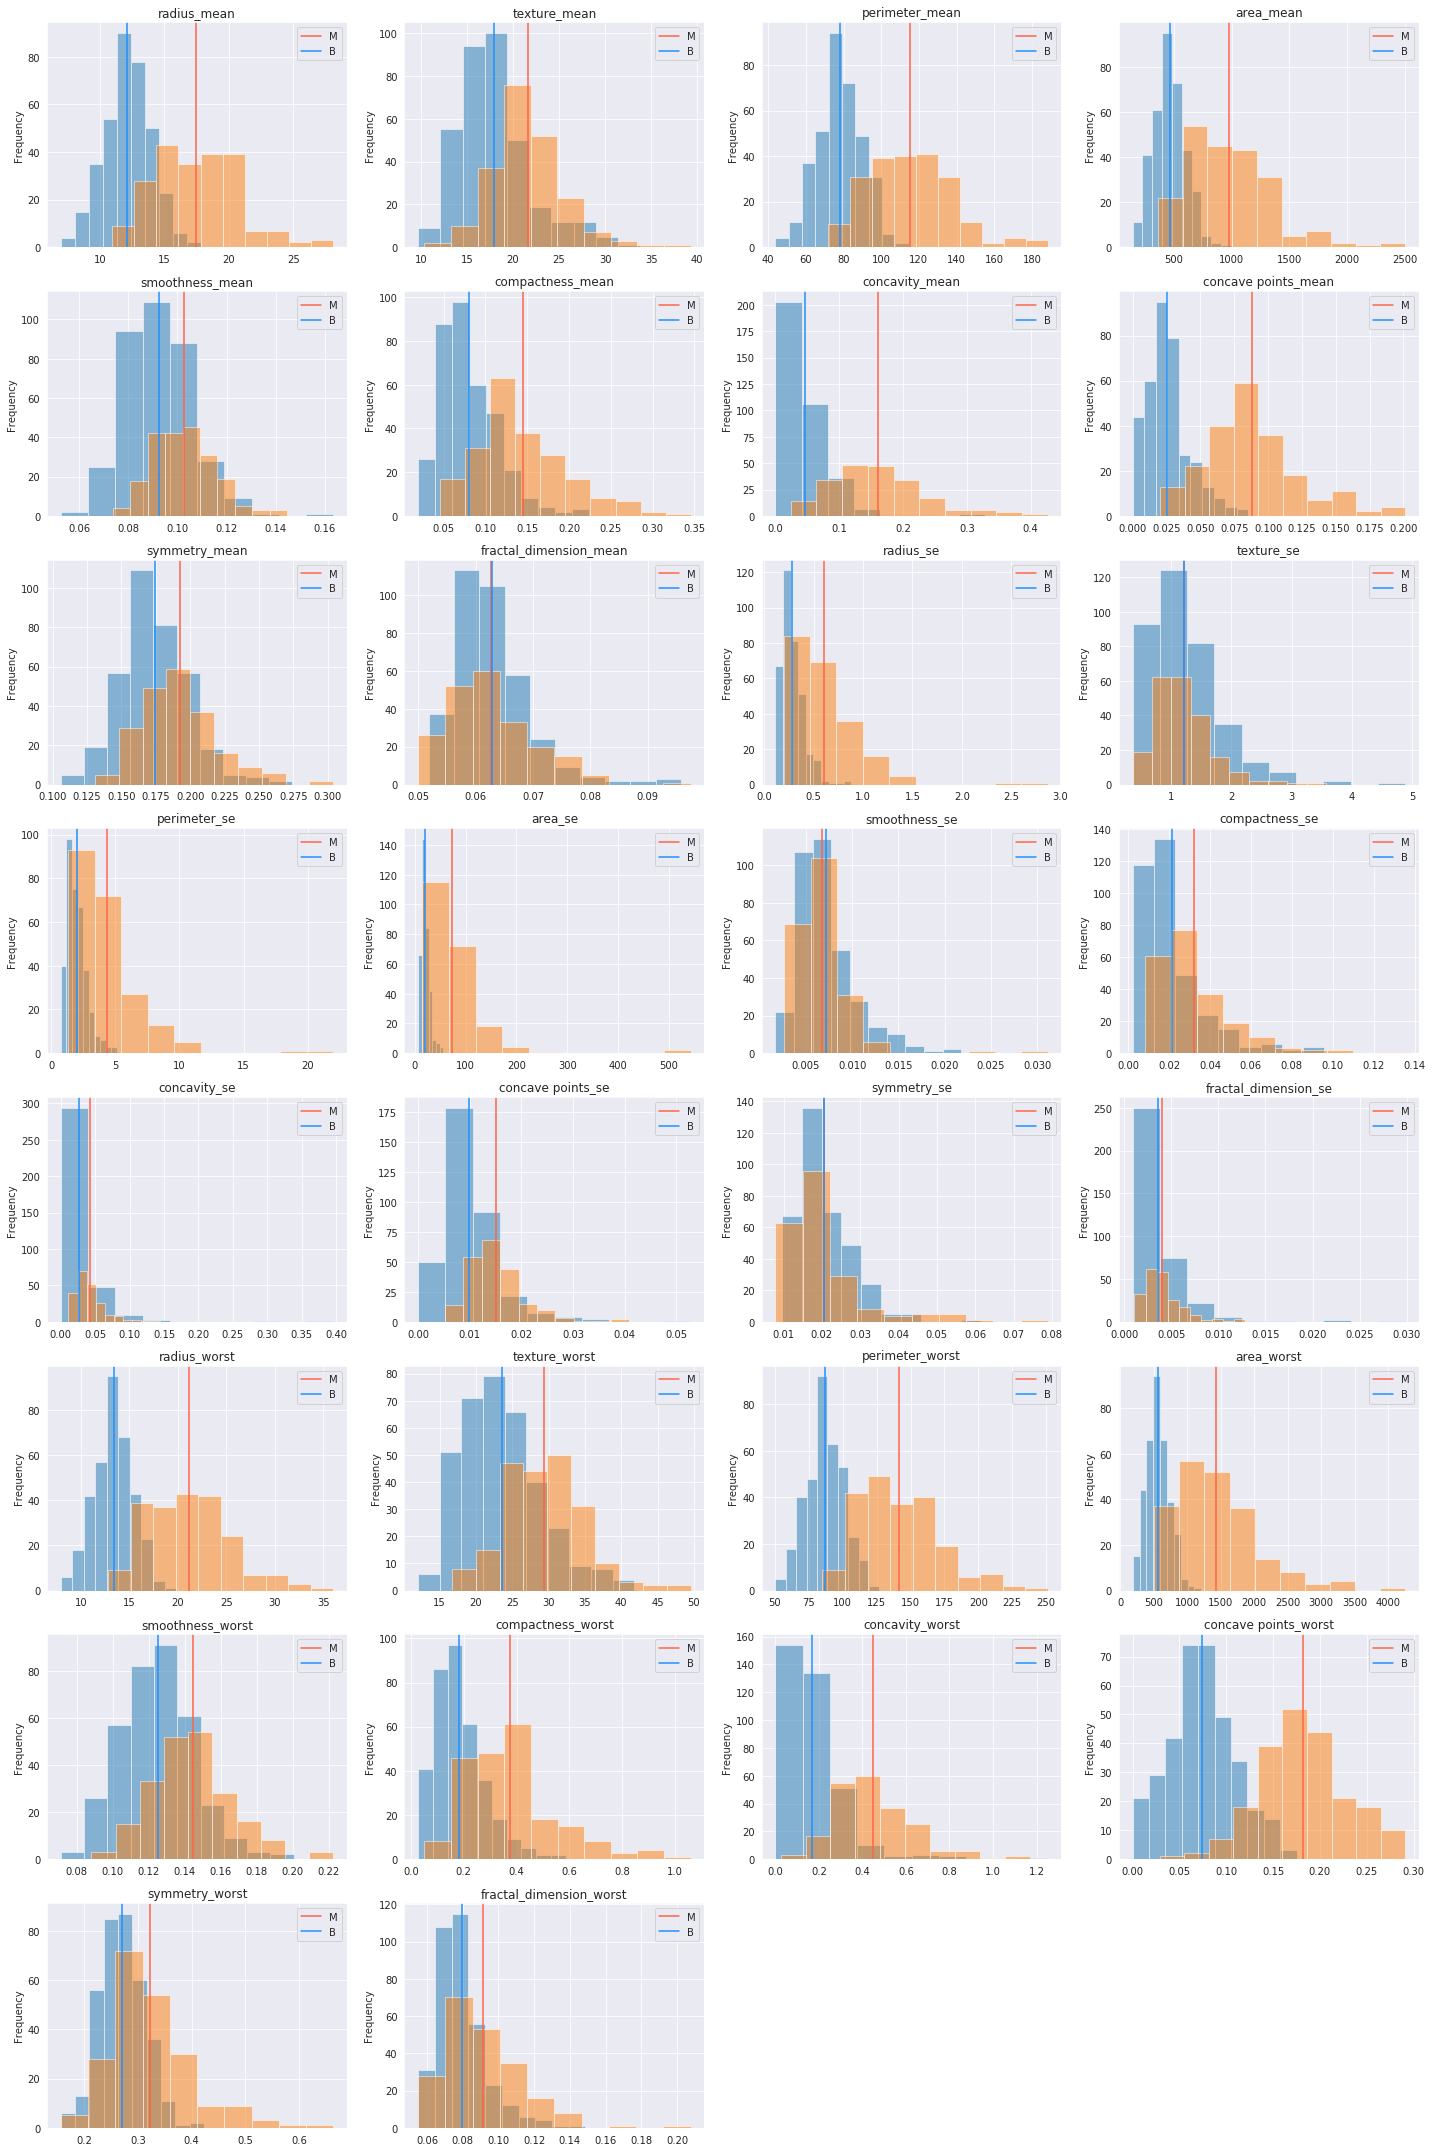

In [5]:
plt.figure(figsize=(20, 30))
for n, i in enumerate(df.columns[1:]):
    plt.subplot(8,4, n + 1)
    df.groupby('diagnosis')[i].plot(kind='hist', alpha=.5)
    plt.axvline(np.mean(df[df['diagnosis']=='M'][i]), color='tomato')
    plt.axvline(np.mean(df[df['diagnosis']=='B'][i]), color='dodgerblue')
    plt.legend(df['diagnosis'].unique())
    plt.title(i)
    plt.tight_layout()

### Reporte de cuáles son los atributos con una mayor similitud en la distribución.

Para distinguir los atributos con mayor similitud en la distribución, se considerará aquellos en que las medias del atributo sean semejantes (considerando las 2 clases del vector objetivo) y que el grado de superposición entre las distribuciones sea relevante.

En esta situación se encuentran los siguientes atributos:

* fractal_dimension_mean
* texture_se
* smoothness_se
* symmetry_se 

### 3. Estimando el porcentaje de overlap en los atributos.

Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. 

Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo. 

In [6]:
# El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

#h1, _ = np.histogram(var1, bins=100)  # estimamos la frecuencia de obs. en 100 espacios definidos 
#h2, _ = np.histogram(var2, bins=100)  # estimamos la frecuencia de obs. en 100 espacios definidos 
#get_minima = np.minimum(h1, h2)       # extraemos el mínimo de observaciones comunes entre h1 y h2 
#intersection = np.true_divide(np.sum(get_minima), np.sum(h2))  # Estimamos la intersección de elementos comunes

La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad. 

Generalice el código de arriba en una función para evaluar el porcentaje de noseparabilidad entre las clases para cada atributo. 

Posteriormente genere un dataframe donde almacenará el nombre del atributo y su porcentaje. 

Ordene este dataframe de forma descendente y preserve.

In [7]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [8]:
lbl = LabelEncoder()
df['diagnosis'] = lbl.fit_transform(df['diagnosis'])

In [9]:
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [10]:
# Función para evaluar el porcentaje de noseparabilidad entre las clases para cada atributo.
def no_separ(dframe):
    attribute=[]
    intersec=[]
    for var in dframe.columns[1:]:
        h1, _ = np.histogram(dframe[dframe['diagnosis']== 0][var], bins=100)
        h2, _ = np.histogram(dframe[dframe['diagnosis']== 1][var], bins=100)
        get_minima = np.minimum(h1,h2)
        intersection = np.true_divide(np.sum(get_minima), np.sum(h2))
        attribute.append(var)
        intersec.append(intersection)
    no_separ_df=pd.DataFrame({'attribute': attribute, 'intersection':intersec})
    no_separ_df_ords=no_separ_df.sort_values(by='intersection', ascending=False)
    return no_separ_df_ords  
    

In [11]:
# Dataframe con nombre del atributo y su porcentaje de comunalidad.
no_separ(df)

,attribute,intersection
9,fractal_dimension_mean,0.886792
15,compactness_se,0.882075
5,compactness_mean,0.872642
29,fractal_dimension_worst,0.872642
10,radius_se,0.867925
21,texture_worst,0.867925
18,symmetry_se,0.863208
8,symmetry_mean,0.858491
1,texture_mean,0.858491
24,smoothness_worst,0.844340


### 4. Selección del modelo utilizando GridSearchCV.

Entrene una serie de modelos SVC con los siguientes hiperparámetros: 

* C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]. 

* gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]. 

Validaciones cruzadas: 10. 

Genere un heatmap en base a los puntajes estimados con GridSearchCV . 

tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .

Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente. 

Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [12]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'radius_mean':'fractal_dimension_worst'], df['diagnosis'], random_state=9605, test_size=.30)

In [14]:
params={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.0000001,0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [15]:
diagnosis_cv=GridSearchCV(SVC(kernel='rbf'), params, cv=10,return_train_score=True)

In [16]:
diagnosis_cv.fit(X_train, y_train)

/home/jcgutierrez/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [17]:
diagnosis_cv_scores= diagnosis_cv.cv_results_['mean_test_score']

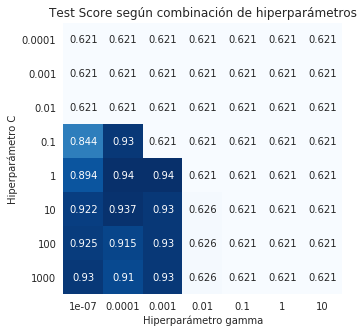

In [18]:
# Heatmap en base a los puntajes estimados con GridSearchCV.
plt.figure(figsize=(5,5))
sn.heatmap(diagnosis_cv_scores.reshape(8,7), xticklabels= params['gamma'],
            yticklabels=params['C'], fmt='.3g',annot=True, cbar=False, cmap='Blues')
plt.ylabel("Hiperparámetro C")
plt.xlabel("Hiperparámetro gamma")
plt.title("Test Score según combinación de hiperparámetros")
plt.show()

El rango en que el hiperparámetro C hace que el modelo presente un desempeño eficiente es [0.1, 1, 10, 100, 1000].

El rango en que el hiperparámetro gamma hace que el modelo presente un desempeño eficiente es [0.0000001,0.0001, 0.001].


In [19]:
# Mejor combinación de hiperparámetros.
print("Mejor Combinacion de Hiperparámetros: {}".format(diagnosis_cv.best_params_))

Mejor Combinacion de Hiperparámetros: {'C': 1, 'gamma': 0.0001}


In [20]:
# Desempeño en la muestra de entrenamiento.
print("Test Score (dada mejor combinación): {}".format(round(diagnosis_cv.best_score_, 4)))

Test Score (dada mejor combinación): 0.9397


### 5. Validación del modelo en el hold-out sample.

Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. 

Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. 

Comente en qué casos el modelo presenta un desempeño deficiente

In [21]:
best_model=diagnosis_cv.best_estimator_.fit(X_train, y_train)

In [22]:
# Predicciones del hold-out sample en base a la mejor combinación de hiperparámetros.
diagnosis_cv_best_pred=best_model.predict(X_test)

In [23]:
# Reporte con las métricas de desempeño clásicas para los modelos de clasificación.
crep=pd.DataFrame(classification_report(y_test, diagnosis_cv_best_pred, target_names=['Benigno','Maligno'],output_dict=True)).drop(columns=['accuracy', 'macro avg']).head(4)
crep

,Benigno,Maligno,weighted avg
f1-score,0.940639,0.894309,0.924112
precision,0.944954,0.887097,0.924315
recall,0.936364,0.901639,0.923977
support,110.000000,61.000000,171.000000


              Benigno    Maligno  weighted avg
f1-score     0.940639   0.894309      0.924112
precision    0.944954   0.887097      0.924315
recall       0.936364   0.901639      0.923977
support    110.000000  61.000000    171.000000


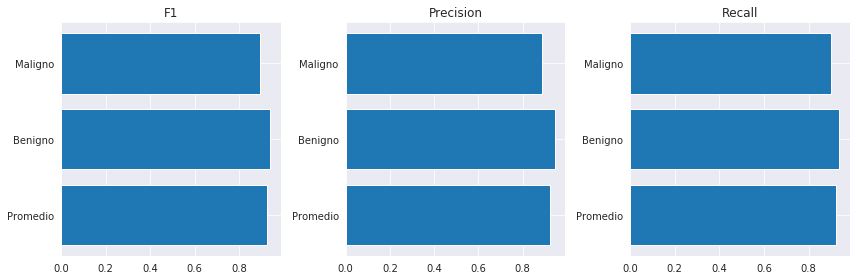

In [24]:
# Métricas modelo SVC Base
fn.model_metrics(crep)

### Comentarios del desempeño del modelo.

El modelo tiene un mejor desempeño para predicir correctamente los casos Benignos que los Malignos, en los 3 indicadores considerados en el reporte (f1-score, Precision y Recall).

Para la clase Benigno el modelo presenta un desempeño superior al 0.936 en todos los indicadores.

Para la clase Maligno el modelo presenta un desempeño superior al 0.887 en todos los indicadores.

El indicador Precision de la clase Maligno es el más bajo (0.887) lo que significa que la proporción de indentificaciones positivas, que se identificó correctamente en esta clase, es más baja.

### 6. Depuración de atributos.

Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45. 

Reporte el desempeño del modelo y comente sobre los nuevos hiperparámetros estimados, así como su desempeño en comparación al modelo del ejercicio 4.
 

Atributos que presentan un coeficiente de overlap menor a 0.45.

* concavity_se
* concavity_mean
* concavity_worst 

In [25]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df.loc[:, ['concavity_se', 'concavity_mean', 'concavity_worst']], df['diagnosis'], random_state=9605, test_size=.30)


In [26]:
X1_train.columns

Index(['concavity_se', 'concavity_mean', 'concavity_worst'], dtype='object')

In [27]:
diagnosis_cv1=GridSearchCV(SVC(kernel='rbf'), params, cv=10)

In [28]:
diagnosis_cv1.fit(X1_train, y1_train)

/home/jcgutierrez/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
diagnosis_cv_scores1= diagnosis_cv1.cv_results_['mean_test_score']

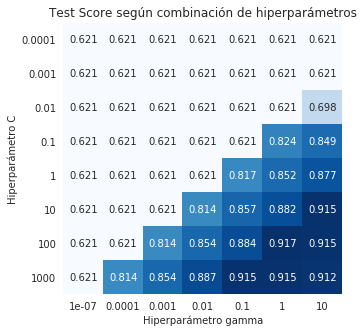

In [30]:
plt.figure(figsize=(5,5))
sn.heatmap(diagnosis_cv_scores1.reshape(8,7), xticklabels= params['gamma'],
            yticklabels=params['C'], fmt='.3g',annot=True, cbar=False, cmap='Blues')
plt.ylabel("Hiperparámetro C")
plt.xlabel("Hiperparámetro gamma")
plt.title("Test Score según combinación de hiperparámetros")
plt.show()

In [31]:
print("Mejor Combinacion de Hiperparámetros Modelo Depurado: {}".format(diagnosis_cv1.best_params_))

Mejor Combinacion de Hiperparámetros Modelo Depurado: {'C': 100, 'gamma': 1}


In [32]:
print("Test Score  Modelo Depurado (dada mejor combinación): {}".format(round(diagnosis_cv1.best_score_, 4)))

Test Score  Modelo Depurado (dada mejor combinación): 0.9171


In [33]:
best_model1=diagnosis_cv1.best_estimator_.fit(X1_train, y1_train)

In [34]:
diagnosis_cv_best_pred1=best_model1.predict(X1_test)

In [35]:
crep1=pd.DataFrame(classification_report(y1_test, diagnosis_cv_best_pred1, target_names=['Benigno','Maligno'],output_dict=True))

In [36]:
crep1

,Benigno,Maligno,accuracy,macro avg,weighted avg
f1-score,0.938053,0.879310,0.918129,0.908682,0.917098
precision,0.913793,0.927273,0.918129,0.920533,0.918602
recall,0.963636,0.836066,0.918129,0.899851,0.918129
support,110.000000,61.000000,0.918129,171.000000,171.000000


In [37]:
crep1=pd.DataFrame(classification_report(y1_test, diagnosis_cv_best_pred1, target_names=['Benigno','Maligno'],output_dict=True)).drop(columns=['accuracy', 'macro avg']).head(4)
crep1

,Benigno,Maligno,weighted avg
f1-score,0.938053,0.879310,0.917098
precision,0.913793,0.927273,0.918602
recall,0.963636,0.836066,0.918129
support,110.000000,61.000000,171.000000


              Benigno    Maligno  weighted avg
f1-score     0.938053   0.879310      0.917098
precision    0.913793   0.927273      0.918602
recall       0.963636   0.836066      0.918129
support    110.000000  61.000000    171.000000


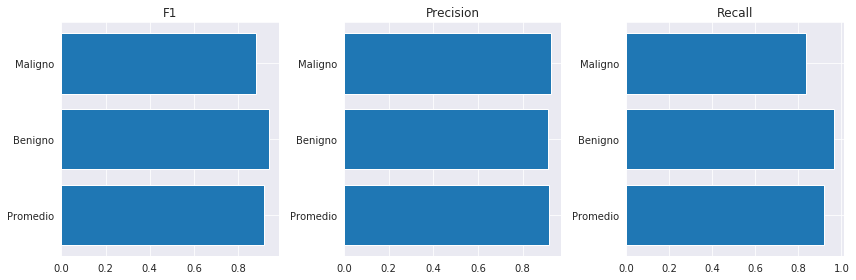

In [38]:
# Métricas modelo SVC Depurado
fn.model_metrics(crep1)

### Comentarios del desempeño del modelo (SVC Depurado).

El modelo tiene un mejor desempeño para predicir correctamente los casos Benignos que los Malignos, considerando f1-score y Recall.

Para el indicador Precision, el modelo tiene un mejor desempeño para predicir correctamente los casos Malignos que los Benignos

Para la clase Benigno el modelo presenta un desempeño superior al 0.913 en todos los indicadores.

Para la clase Maligno el modelo presenta un desempeño superior al 0.836 en todos los indicadores.

El indicador Recall de la clase Maligno es el más bajo (0.836), lo que significa que la proporción de positivos reales que se identificó correctamente en esta clase es más baja.

### 7. Comparación de desempeño entre modelos.

El modelo SVC depurado presenta un desempeño más bajo que el modelo anterior (Base), considerando el indicador f1-score.

En el caso del indicador Precision, el modelo depurado presenta un desempeño más alto que el modelo anterior, para la clase Maligno. Para la clase Benigno presenta un desempeño más bajo.

En el caso del indicador Recall, el modelo depurado presenta un desempeño más alto que el modelo anterior, para la clase Benigno. Para la clase Maligno presenta un desempeño más bajo.


## Gráficos comparación desempeño modelos.

In [39]:
m1_f1_1, m1_f1_2, m1_f1_avg, m1_prec_1, m1_prec_2, m1_prec_avg, m1_rec_1,m1_rec_2, m1_rec_avg= fn.vals_report(crep)
m2_f1_1, m2_f1_2, m2_f1_avg, m2_prec_1, m2_prec_2, m2_prec_avg, m2_rec_1,m2_rec_2, m2_rec_avg= fn.vals_report(crep1)

### Comparación F1 Score

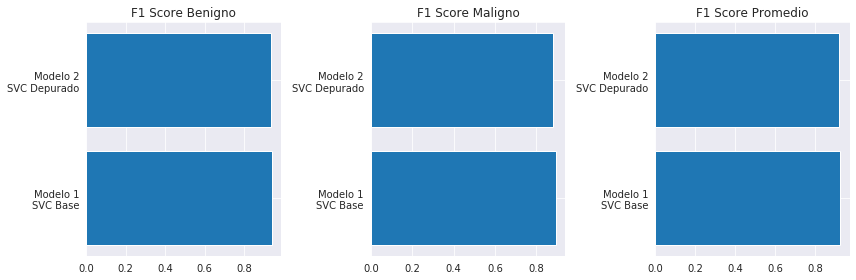

In [40]:
plt.figure(figsize=(12,4))
plt. subplot (1,3,1)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'], [m1_f1_1,m2_f1_1])
plt.title("F1 Score Benigno")
plt. subplot (1,3,2)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'],[m1_f1_2,m2_f1_2])
plt.title("F1 Score Maligno")
plt. subplot (1,3,3)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'], [m1_f1_avg,m2_f1_avg])
plt.title("F1 Score Promedio")
plt.tight_layout()

### Comparación Precision

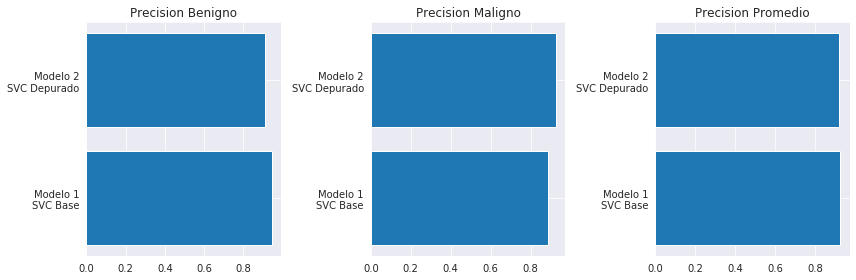

In [41]:
plt.figure(figsize=(12,4))
plt. subplot (1,3,1)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'], [m1_prec_1,m2_prec_1])
plt.title("Precision Benigno")
plt. subplot (1,3,2)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'],[m1_prec_2,m2_prec_2])
plt.title("Precision Maligno")
plt. subplot (1,3,3)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'], [m1_prec_avg,m2_prec_avg])
plt.title("Precision Promedio")
plt.tight_layout()

### Comparación Recall

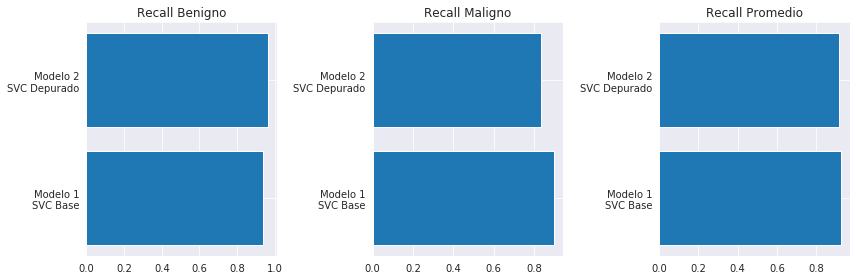

In [42]:
plt.figure(figsize=(12,4))
plt. subplot (1,3,1)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'], [m1_rec_1,m2_rec_1])
plt.title("Recall Benigno")
plt. subplot (1,3,2)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'],[m1_rec_2,m2_rec_2])
plt.title("Recall Maligno")
plt. subplot (1,3,3)
plt.barh(['Modelo 1\nSVC Base', 'Modelo 2\nSVC Depurado'], [m1_rec_avg,m2_rec_avg])
plt.title("Recall Promedio")
plt.tight_layout()